In [4]:
# Training the model parameters
skema_test = 2
batch_size = 16
learning_rate = 0.001
num_epochs = 120
lambda_ = 0.001
T = [2,5,10,25,50,100]

In [5]:
import pandas as pd
import pickle
import numpy as np
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def load_pickle(filename):
    with open(filename, 'rb') as file:
        # Use pickle.load() to deserialize and load the data
        loaded_data = pickle.load(file)
    return loaded_data

def seperate_input_output(dataset):
    X,y = [],[]
    for key,val in dataset.items():
        X.append(val[0])
        y.append(val[1])
    return np.array(X),np.array(y)
    
def process_dataset(dataset,validation_stasiun_name):
    val_dataset = {}
    train_dataset = {}
    for key, val in dataset.items():
        if key in validation_stasiun_name:
            val_dataset[key] = dataset[key]
        else:
            train_dataset[key] = dataset[key]
    X_train, y_train = seperate_input_output(train_dataset)
    X_val, y_val = seperate_input_output(val_dataset)
    return X_train, y_train, X_val, y_val

def return_period(data: np.ndarray ,T : int) -> float:
    """
    Function to calculate return periode
    Args:
        Data: vector of annual max precipitation
        T   : Return period number
    """
    fit_distribution = stats.gumbel_r.fit(data)
    return_period_value = stats.gumbel_r.ppf([1-(1/T)], *fit_distribution)
    
    return  return_period_value

def cal_fit_distribution(data):
    """
    Function to calculate the parameter by fitting the data into gumbel distribution
    Args:
        data: annual max precipitation
    returns:
        fit_distribution: parameter of fitted distribution
    """
    fit_distribution = stats.gumbel_r.fit(data)
    return fit_distribution

In [6]:
# Open dataset
import random

dataset = load_pickle("Dataset Approach 2.pkl")
data1 = pd.read_excel(f"C:/Users/62812/Documents/Kerjaan Meteorologi/GPM-Correction/GPM-Correction/data/Skema Testing {skema_test}.xlsx")
stasiun_test = list(data1['Nama Stasiun'].unique())
#stasiun_test = random.sample(stasiun_test, 10)

pu_gpm_raw = {} # pu_gpm_raw is a combination of pu_gpm_test and pu_gpm_train
pu_gpm_test = {}
pu_gpm_train = {}
for key,val in dataset.items():
    pu = []
    for t in T:
        pu.append(return_period(data= val[0], T = t))
    pu = np.reshape(np.array(pu),-1)
    pu_gpm_raw[key] = pu
    if key in stasiun_test:
        pu_gpm_test[key] = pu
    else:
        pu_gpm_train[key] = pu

X_train, y_train, X_val, y_val = process_dataset(dataset= dataset, validation_stasiun_name = stasiun_test)

X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
y_train_tensor = torch.FloatTensor(y_train)

## Building Data Loader

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X_sample = self.X[idx]
        y_sample = self.y[idx]
        
        return X_sample, y_sample
    
def create_data_loader(X: torch.tensor,
                       y: torch.tensor,
                       batch_size: int,
                       shuffle: bool):
    """
    Function to create data laoder
    Args:
        X: an array of the first tropical cyclone sequence 
        y: an array of the tropical cyclone sequence after X
        batch_size: batch size 
        shuffle: suffle the data while training, make it false when creating data loader for validation
    Returns:
        data_loader: data loader 
    
    """
    custom_dataset = CustomDataset(X, y)    
    data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader

In [6]:
train_loader = create_data_loader(X = X_train_tensor, y = y_train_tensor, batch_size = batch_size, shuffle = True)
val_loader = create_data_loader(X = X_val_tensor, y = y_val_tensor, batch_size = batch_size, shuffle = False)

#### Create Model

In [7]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        # Add input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.SiLU())
        # Add hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.Dropout(0.2))
        # Add output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def inference_dl(model,X):
    y_pred = model(X)
    return y_pred

def eval_model(model, X, y_true, criterion):
    model.eval()
    with torch.no_grad():
        y_pred_tensor = inference_dl(model,x)
        mse = criterion(y_pred_tensor, y_true)
    model.train()
    return mse,y_pred_tensor

# Define input shape, hidden layer sizes, and output shape
input_size = 20
hidden_sizes = [64,32,16]  # Example hidden layer sizes, you can adjust these as needed
output_size = 6

# Create an instance of the MLP model
model = MLP(input_size, hidden_sizes, output_size)

# Print the model architecture
print(model)

MLP(
  (model): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=6, bias=True)
  )
)


### Train Model

In [8]:
# Define loss function and optimize
train_loss, eval_loss = [],[]
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # # L2 regularization
        # l2_reg = torch.tensor(0.)
        # for param in model.parameters():
        #     l2_reg += torch.norm(param)
        # loss += lambda_ * l2_reg
        loss.backward()
        optimizer.step()
        
    mse_eval,y_pred = eval_model(model, X_val_tensor, y_val_tensor, criterion)
    train_loss.append(loss.item())
    eval_loss.append(mse_eval)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Eval Loss: {mse_eval}')

Epoch [1/120], Train Loss: 29690.2168, Eval Loss: 33770.015625
Epoch [2/120], Train Loss: 35732.1484, Eval Loss: 31509.35546875
Epoch [3/120], Train Loss: 30075.2422, Eval Loss: 29110.7109375
Epoch [4/120], Train Loss: 24754.5117, Eval Loss: 26564.376953125
Epoch [5/120], Train Loss: 32993.4102, Eval Loss: 23807.830078125
Epoch [6/120], Train Loss: 18934.8086, Eval Loss: 20853.890625
Epoch [7/120], Train Loss: 19297.9258, Eval Loss: 17763.025390625
Epoch [8/120], Train Loss: 7894.7612, Eval Loss: 14623.650390625
Epoch [9/120], Train Loss: 7540.6416, Eval Loss: 11585.251953125
Epoch [10/120], Train Loss: 16247.9688, Eval Loss: 8729.755859375
Epoch [11/120], Train Loss: 9473.5117, Eval Loss: 6207.85498046875
Epoch [12/120], Train Loss: 18318.7715, Eval Loss: 4183.236328125
Epoch [13/120], Train Loss: 4957.2827, Eval Loss: 2719.599853515625
Epoch [14/120], Train Loss: 4427.7671, Eval Loss: 1864.669189453125
Epoch [15/120], Train Loss: 12655.7373, Eval Loss: 1432.021240234375
Epoch [16/120

### Machine Learning Model

In [18]:
import xgboost as xgb
import numpy as np

# Define your XGBoost regression model
class XGBoostRegression:
    def __init__(self, input_shape, output_shape, n_estimators=1000, learning_rate=0.01, max_depth=5):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth

        # Initialize the XGBoost regressor
        self.model = xgb.XGBRegressor(
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            max_depth=self.max_depth
        )

    def fit(self, X_train, y_train):
        # Reshape the input and output data
        X_train = np.array(X_train).reshape(-1, self.input_shape)
        y_train = np.array(y_train).reshape(-1, self.output_shape)

        # Fit the model to the training data
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        # Reshape the input data
        X_test = np.array(X_test).reshape(-1, self.input_shape)

        # Make predictions
        predictions = self.model.predict(X_test)

        return predictions

# Define hyperparameters
input_shape = 20
output_shape = 6
n_estimators = 100
learning_rate = 0.1
max_depth = 3

# Create an instance of the XGBoost regression model
xgb_model = XGBoostRegression(input_shape, output_shape, n_estimators, learning_rate, max_depth)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
predictions_ML = xgb_model.predict(X_val)

In [19]:
# Calculate Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error,r2_score
mse = mean_squared_error(y_val, predictions_ML)
print("Mean Squared Error (MSE):", mse)
r2 = r2_score(y_val, predictions)
print("R2 Scored:", r2) 

Mean Squared Error (MSE): 1468.4697901397233
R2 Scored: 0.2736832727807254


In [21]:
predictions

array([[144.5817  , 208.84457 , 223.75044 , 260.65256 , 300.86237 ,
        320.98373 ],
       [120.68752 , 153.52113 , 179.46315 , 198.41481 , 224.50174 ,
        236.61555 ],
       [126.32879 , 153.10117 , 174.27716 , 229.9773  , 255.30688 ,
        277.99    ],
       [130.23335 , 174.07773 , 187.95557 , 223.7012  , 245.36227 ,
        258.95645 ],
       [100.39842 , 142.08853 , 166.6465  , 177.90643 , 205.74957 ,
        220.7565  ],
       [129.96935 , 163.72963 , 183.25061 , 214.25584 , 229.93515 ,
        262.20316 ],
       [ 82.26271 , 122.06113 , 146.81364 , 194.51768 , 210.65193 ,
        201.02747 ],
       [121.09216 , 153.53975 , 175.47755 , 217.6715  , 249.82301 ,
        278.2814  ],
       [119.695335, 141.94571 , 168.37889 , 191.09775 , 193.69122 ,
        228.67717 ],
       [118.80754 , 153.28566 , 165.01245 , 184.53697 , 203.57243 ,
        219.91893 ],
       [115.071976, 184.53407 , 200.99895 , 250.32808 , 281.18774 ,
        312.6249  ],
       [120.378746, 1

In [22]:
y_pred_ML = predictions
y_stas = y_val
y_gpm = []
for key,val in pu_gpm_test.items():
    y_gpm.append(list(val))
y_gpm = np.array(y_gpm)

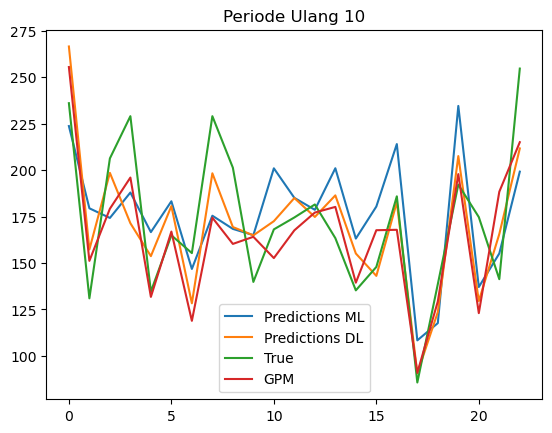

In [24]:
import matplotlib.pyplot as plt
m = 2
plt.plot(np.arange(0,len(y_val[:,5])),(predictions[:,m]), label = "Predictions ML")
plt.plot(np.arange(0,len(y_val[:,5])),(y_pred[:,m]), label = "Predictions DL")
plt.plot(np.arange(0,len(y_val[:,5])), y_val[:,m], label = "True")
plt.plot(np.arange(0,len(y_val[:,5])), y_gpm[:,m], label = "GPM")
plt.title(f"Periode Ulang {T[m]}")
plt.legend()
plt.show()

### Evaluasi Perfomance

In [16]:
class Evaluation:
    def __init__(self, model):
        self.model = model

    def calculate_mse(self, y_pred, y_true):
        mse = mean_squared_error(y_pred=y_pred, y_true= y_true)
        return mse

    def calculate_rmse(self, y_pred, y_true):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse
    
    def calculate_nmse_mean(self, y_pred, y_true):
        rmse = self.calculate_rmse(y_pred=y_pred , y_true=y_true)
        nmse_mean = rmse/np.mean(y_true)
        return nmse_mean
    
    def calculate_nmse_std(self, y_pred, y_true):
        rmse = self.calculate_rmse(y_pred=y_pred , y_true=y_true)
        nmse_std = rmse/np.std(y_true)
        return nmse_std
    
    def calculate_nmse_min_max(self, y_pred, y_true):
        rmse = self.calculate_rmse(y_pred=y_pred, y_true=y_true)
    
        # Menangani kasus ketika nilai maksimum dan minimum sama
        if np.max(y_true) == np.min(y_true):
        # Handle secara khusus untuk menghindari pembagian oleh nol
            nmse_min_max = 0.0
        else:
            nmse_min_max = rmse / (np.max(y_true) - np.min(y_true))
    
        return nmse_min_max
        
evaluation = Evaluation(model)

In [17]:
def plot_boxplot_nmse(nmse_values,T, skema_simulasi):
    # Buat boxplot
    fig, ax = plt.subplots()
    ax.boxplot(nmse_values, labels=T)
    ax.set_xlabel('Return Period (Yr)')
    ax.set_ylabel('NMSE Mean')
    ax.set_title(f'Difference NMSE Mean {skema_simulasi}')
    plt.show()    

In [18]:
nmse_mean_pred_ML_stas = []
nmse_mean_gpm_stas = []
nmse_mean_pred_DL_stas = []
for i in range(y_pred_ML.shape[1]):
    nmse_mean_pred_ML_stas.append(evaluation.calculate_nmse_mean(y_pred_ML[:,i], y_stas[:,i]))
    nmse_mean_gpm_stas.append(evaluation.calculate_nmse_mean(y_gpm[:,i], y_stas[:,i]))
    nmse_mean_pred_DL_stas.append(evaluation.calculate_nmse_mean(y_pred[:,i], y_stas[:,i]))

In [19]:
nmse_mean_pred_ML_stas

[0.19886979807748303,
 0.19967363452032666,
 0.18675937548347507,
 0.18894188056304215,
 0.21441955171807067,
 0.21429605733994814]

In [20]:
nmse_mean_pred_DL_stas

[0.19096999984060592,
 0.17896283045138237,
 0.1716577311094065,
 0.17668153055909355,
 0.18442879071301,
 0.18734228628127716]

In [21]:
nmse_mean_gpm_stas

[0.1591697141359972,
 0.1544347738715816,
 0.15809247938176813,
 0.164759377072338,
 0.16992693076123772,
 0.1748392267372046]

In [22]:
stasiun_test

['Stasiun Meteorologi Cut Nyak Dhien Nagan Raya',
 'Stasiun Meteorologi Binaka',
 'Stasiun Klimatologi Padang Pariaman',
 'Stasiun Meteorologi Hang Nadim',
 'Stasiun Meteorologi Sultan Thaha',
 'Stasiun Meteorologi Sultan Mahmud Badaruddin II',
 'Stasiun Klimatologi Bogor',
 'Stasiun Meteorologi Tunggul Wulung',
 'Stasiun Meteorologi Maritim Tanjung Priok',
 'Stasiun Meteorologi Juanda',
 'Stasiun Klimatologi Mempawah',
 'Stasiun Meteorologi Susilo',
 'Stasiun Meteorologi H. Asan',
 'Stasiun Meteorologi Juwata',
 'Stasiun Meteorologi I Gusti Ngurah Rai',
 'Stasiun Meteorologi David Constatijn Saudale',
 'Stasiun Meteorologi Tardamu',
 'Stasiun Klimatologi Maros',
 'Stasiun Meteorologi Mutiara Sis-Al Jufri',
 'Stasiun Meteorologi Sangia Ni Bandera',
 'Stasiun Meteorologi Namlea',
 'Stasiun Meteorologi Oesman Sadik',
 'Stasiun Meteorologi Sentani',
 'Stasiun Meteorologi Mozez Kilangin']